In [2]:
import pandas as pd
import numpy as np
import os
import warnings
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from tqdm import tqdm
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    f1_score, accuracy_score, recall_score, precision_score, 
    precision_recall_curve, confusion_matrix, roc_auc_score, 
    matthews_corrcoef, roc_curve
)

warnings.filterwarnings("ignore")


### 📊 Metric Calculation Utilities


In [3]:

def get_aupr(pre, rec):
    pr_value = 0.0
    for ii in range(len(rec[:-1])):
        x_r, x_l = rec[ii], rec[ii+1]
        y_t, y_b = pre[ii], pre[ii+1]
        tempo = abs(x_r - x_l) * (y_t + y_b) * 0.5
        pr_value += tempo
    return pr_value

def scores(y_test, y_pred, th=0.5):           
    y_predlabel = [(0. if item < th else 1.) for item in y_pred]
    tn, fp, fn, tp = confusion_matrix(y_test, y_predlabel).flatten()
    SPE = tn / (tn + fp)
    MCC = matthews_corrcoef(y_test, y_predlabel)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    sen, spe, pre, f1, mcc, acc, auc, tn, fp, fn, tp = np.array([
        recall_score(y_test, y_predlabel), SPE, precision_score(y_test, y_predlabel), 
        f1_score(y_test, y_predlabel), MCC, accuracy_score(y_test, y_predlabel), 
        roc_auc_score(y_test, y_pred), tn, fp, fn, tp
    ])
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    aupr = get_aupr(precision, recall)
    return [aupr, auc, f1, acc, sen, spe, pre, fpr, tpr, precision, recall]


# --- Utility Functions ---

In [4]:
def combine_features(phage_dna, host_dna, phage_pro, host_pro):
    combined = np.concatenate([phage_dna, host_dna, phage_pro, host_pro], axis=1)
    return combined

In [5]:
def load_feature_vector(file_path):
    return np.loadtxt(file_path)

In [6]:
def obtain_features(phage_list, host_list, labels, dna_base, pro_base):
    X_phage_dna, X_host_dna = [], []
    X_phage_pro, X_host_pro = [], []
    for p, h in zip(phage_list, host_list):
        X_phage_dna.append(load_feature_vector(os.path.join(dna_base, 'phage', f'{p}.txt')))
        X_host_dna.append(load_feature_vector(os.path.join(dna_base, 'bacteria', f'{h}.txt')))
        X_phage_pro.append(load_feature_vector(os.path.join(pro_base, 'phage', f'{p}.txt')))
        X_host_pro.append(load_feature_vector(os.path.join(pro_base, 'bacteria', f'{h}.txt')))
    return (np.array(X_phage_dna), np.array(X_host_dna),
            np.array(X_phage_pro), np.array(X_host_pro),
            np.array(labels))

# --- Load interaction matrix ---

In [10]:
interaction_matrix_path = "./ordinal_dataset_features/ordinal_interaction_matrix.csv"
csv_output_path = "ordinal_dataset_features/interaction_matrix.csv"

dna_base = './ordinal_dataset_features/dna_features_ordinal_data'
pro_base = './ordinal_dataset_features/prot_features_ordinal_data'

In [28]:
interaction_matrix_path = "D:\\Uni\\phi_prediction\\classic pred\\phl_dataset_features\\phage_host_interactions (1).csv"

dna_base = 'D:\\Uni\\phi_prediction\\classic pred\\phl_dataset_features\\dna_features'
pro_base = 'D:\\Uni\\phi_prediction\\classic pred\\phl_dataset_features\\protein_features'

In [11]:
# Get list of phages and hosts based on files present
if interaction_matrix_path.endswith('.xlsx'):
    #Transposed because this dataset has another the wrong shape
    df = pd.read_excel(interaction_matrix_path, index_col=0).T
    df.to_csv(csv_output_path)
    interaction_matrix_path = csv_output_path # Update path to CSV
else:
    df = pd.read_csv(interaction_matrix_path, index_col=0, sep=";")

valid_phages = set([f.split('.')[0] for f in os.listdir(dna_base+"/phage") if f.endswith('.txt')])
valid_hosts = set([f.split('.')[0] for f in os.listdir(pro_base+"/bacteria") if f.endswith('.txt')])
#filter unused interaction since matrix to large
df = df.loc[df.index.intersection(valid_hosts), df.columns.intersection(valid_phages)]
phages = df.columns.tolist()
hosts = df.index.tolist()
print(len(phages))
print(len(hosts))


96
402


# Prepare data as list of (phage, host, label)

In [12]:
all_data = []

for p in phages:
    for h in hosts:
        label = df.loc[h, p]
        if pd.isna(label):
            continue  # Skip missing values
        binary_label = 1 if label >= 1 else 0
        all_data.append([p, h, binary_label])

# Dummy Classifier as Baseline

In [ ]:
from sklearn.dummy import DummyClassifier

# Prepare full dataset for baseline
phage_list = [x[0] for x in all_data]
host_list = [x[1] for x in all_data]
labels = [x[2] for x in all_data]

# Extract features for the full dataset
X_phage_dna, X_host_dna, X_phage_pro, X_host_pro, y_all = obtain_features(
    phage_list, host_list, labels, dna_base, pro_base
)
X_all = combine_features(X_phage_dna, X_host_dna, X_phage_pro, X_host_pro)

# Train and evaluate DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_all, y_all)
y_dummy_prob = dummy.predict_proba(X_all)[:, 1]

# Evaluate with custom metrics
dummy_metrics = scores(y_all, y_dummy_prob)

# Print metrics
print(f"Dummy Classifier Metrics:")
print(f"AUPR: {dummy_metrics[0]:.4f}")
print(f"AUC:  {dummy_metrics[1]:.4f}")
print(f"F1:   {dummy_metrics[2]:.4f}")
print(f"ACC:  {dummy_metrics[3]:.4f}")
print(f"SEN:  {dummy_metrics[4]:.4f}")
print(f"SPE:  {dummy_metrics[5]:.4f}")
print(f"PREC: {dummy_metrics[6]:.4f}")


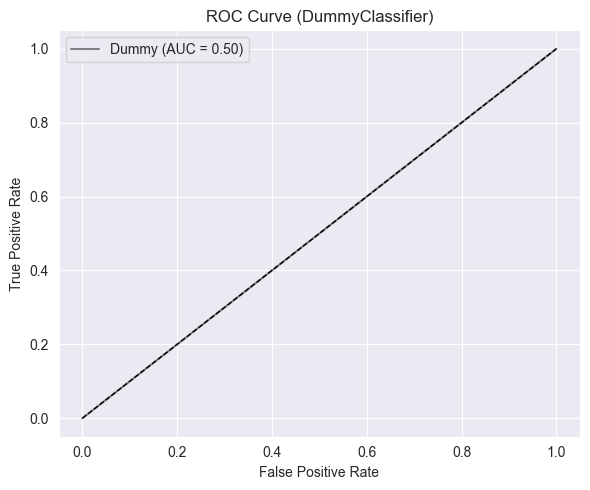

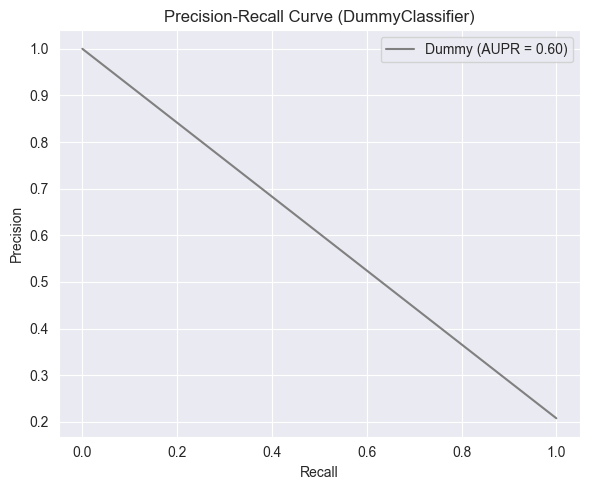

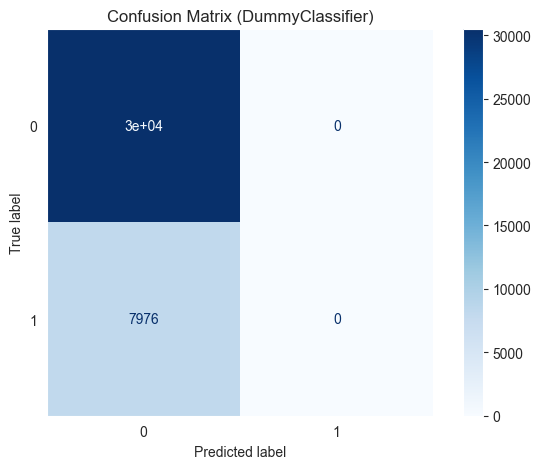

In [13]:
import matplotlib.pyplot as plt

# Unpack for plotting
fpr, tpr = dummy_metrics[7], dummy_metrics[8]
precision_curve, recall_curve = dummy_metrics[9], dummy_metrics[10]

# --- ROC Curve ---
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Dummy (AUC = {dummy_metrics[1]:.2f})", color='gray')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (DummyClassifier)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Precision-Recall Curve ---
plt.figure(figsize=(6, 5))
plt.plot(recall_curve, precision_curve, label=f"Dummy (AUPR = {dummy_metrics[0]:.2f})", color='gray')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (DummyClassifier)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Confusion Matrix ---
from sklearn.metrics import ConfusionMatrixDisplay

y_dummy_label = [1 if p >= 0.5 else 0 for p in y_dummy_prob]

ConfusionMatrixDisplay.from_predictions(y_all, y_dummy_label, cmap='Blues')
plt.title("Confusion Matrix (DummyClassifier)")
plt.grid(False)
plt.tight_layout()
plt.show()

### 🧪 Model Training and Evaluation (with Metrics)

In [ ]:
from sklearn.model_selection import train_test_split

# Prepare full feature set for grid search (using all data)
all_phages = [x[0] for x in all_data]
all_hosts = [x[1] for x in all_data]
all_labels = [x[2] for x in all_data]

X_phage_dna, X_host_dna, X_phage_pro, X_host_pro, y_all = obtain_features(
    all_phages, all_hosts, all_labels, dna_base, pro_base)
X_all_combined = combine_features(X_phage_dna, X_host_dna, X_phage_pro, X_host_pro)

# Estimate imbalance
imbalance = sum([1 for i in y_all if i == 1]) / sum([1 for i in y_all if i == 0])

# Set up model and parameter grid
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.1, 0.3],
    'scale_pos_weight': [1, 1/imbalance]
}

# Grid search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='average_precision', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_all_combined, y_all)
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)


In [18]:
results_all = []
fprs, tprs, precisions, recalls = [], [], [], []
kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
labels = [row[2] for row in all_data]

for fold, (train_idx, val_idx) in enumerate(kf.split(all_data, labels)):
    print(f"Fold {fold+1}")

    train_set = [all_data[i] for i in train_idx]
    val_set = [all_data[i] for i in val_idx]

    train_phages = [x[0] for x in train_set]
    train_hosts = [x[1] for x in train_set]
    train_labels = [x[2] for x in train_set]

    val_phages = [x[0] for x in val_set]
    val_hosts = [x[1] for x in val_set]
    val_labels = [x[2] for x in val_set]

    X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr, y_train = obtain_features(
        train_phages, train_hosts, train_labels, dna_base, pro_base)
    X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val, y_val = obtain_features(
        val_phages, val_hosts, val_labels, dna_base, pro_base)

    X_train_combined = combine_features(X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr)
    X_val_combined = combine_features(X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val)

    # Use the best parameters
    best_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', **best_params)
    best_model.fit(X_train_combined, y_train)
    y_pred_prob = best_model.predict_proba(X_val_combined)[:, 1]

    fold_metrics = scores(y_val, y_pred_prob)
    results_all.append(fold_metrics[:7])
    fprs.append(fold_metrics[7])
    tprs.append(fold_metrics[8])
    precisions.append(fold_metrics[9])
    recalls.append(fold_metrics[10])

    print(f"Fold {fold+1} | AUPR: {fold_metrics[0]:.4f}, AUC: {fold_metrics[1]:.4f}, F1: {fold_metrics[2]:.4f}, Acc: {fold_metrics[3]:.4f}")


Fold 1
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fold 1 | AUPR: 0.8190, AUC: 0.9229, F1: 0.7244, Acc: 0.8655
Fold 2
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fold 2 | AUPR: 0.8294, AUC: 0.9248, F1: 0.7307, Acc: 0.8698
Fold 3
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fold 3 | AUPR: 0.8207, AUC: 0.9224, F1: 0.7392, Acc: 0.8744
Fold 4
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fold 4 | AUPR: 0.8136, AUC: 0.9190, F1: 0.7384, Acc: 0.8682
Fold 5
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fold 5 | AUPR: 0.8032, AUC: 0.9133, F1: 0.7164, Acc: 0.8684


### 📉 Plotting Metrics Across Folds

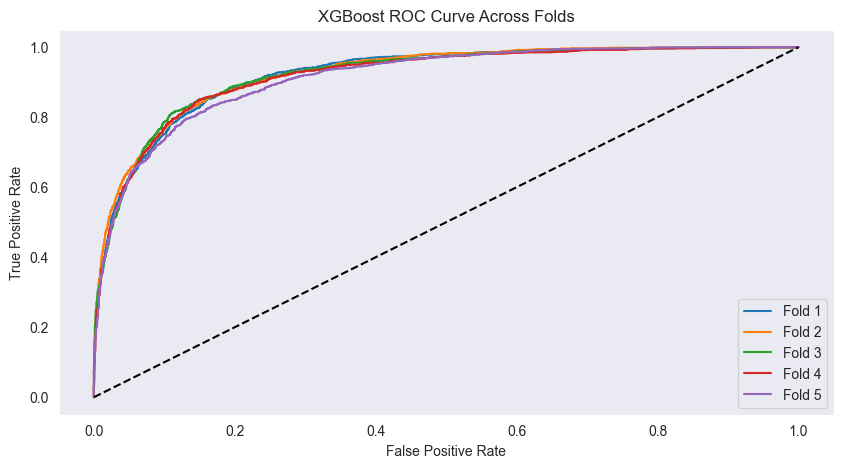

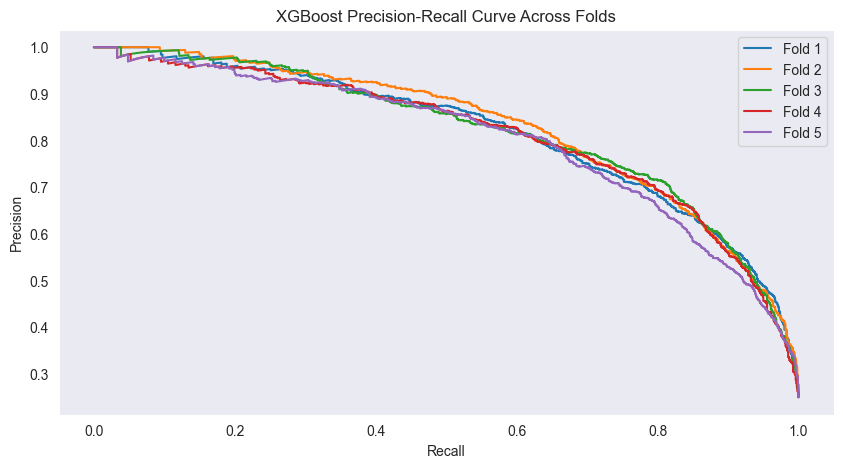

In [19]:


# Plot ROC Curves
plt.figure(figsize=(10, 5))
for i in range(len(fprs)):
    plt.plot(fprs[i], tprs[i], label=f'Fold {i+1}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("XGBoost ROC Curve Across Folds")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Plot PR Curves
plt.figure(figsize=(10, 5))
for i in range(len(precisions)):
    plt.plot(recalls[i], precisions[i], label=f'Fold {i+1}')
plt.title("XGBoost Precision-Recall Curve Across Folds")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()


### 📦 Summary Boxplot of All Metrics

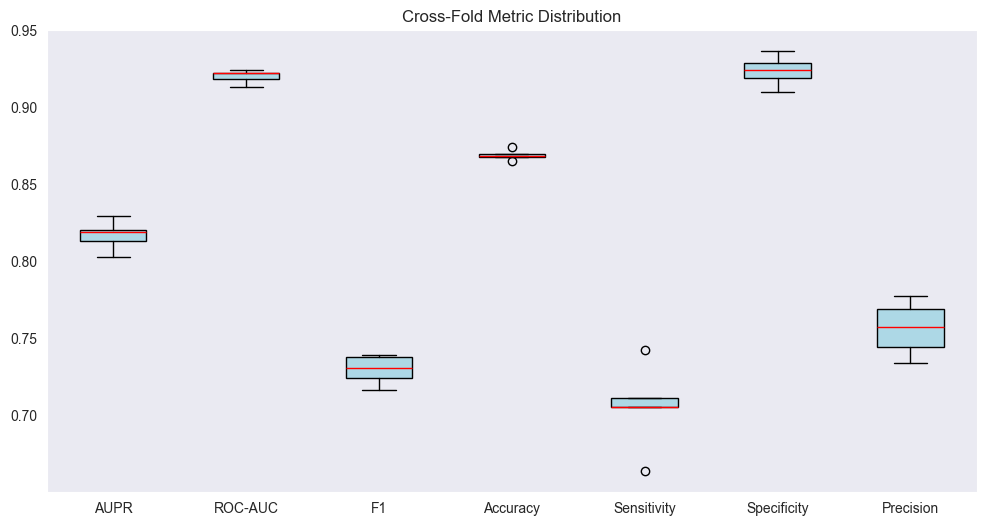

In [20]:

metric_names = ["AUPR", "ROC-AUC", "F1", "Accuracy", "Sensitivity", "Specificity", "Precision"]
results_array = np.array(results_all)

plt.figure(figsize=(12, 6))
plt.boxplot(results_array, labels=metric_names, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='black'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='black'))
plt.title("Cross-Fold Metric Distribution")
plt.grid()
plt.show()


### 📋 Fold-wise Metric Table


In [21]:

results_df = pd.DataFrame(results_all, columns=metric_names)
results_df.index = [f"Fold {i+1}" for i in range(len(results_all))]
display(results_df)

print("Mean Metrics:")
display(results_df.mean())


,AUPR,ROC-AUC,F1,Accuracy,Sensitivity,Specificity,Precision
Fold 1,0.818991,0.922900,0.724409,0.865540,0.705521,0.919016,0.744337
Fold 2,0.829404,0.924831,0.730739,0.869766,0.705521,0.924654,0.757825
Fold 3,0.820683,0.922362,0.739234,0.874376,0.711435,0.928773,0.769295
Fold 4,0.813580,0.918970,0.738368,0.868229,0.742901,0.910069,0.733889
Fold 5,0.803163,0.913280,0.716356,0.868396,0.663853,0.936699,0.777878


Mean Metrics:


AUPR           0.817164
ROC-AUC        0.920469
F1             0.729821
Accuracy       0.869261
Sensitivity    0.705846
Specificity    0.923842
Precision      0.756645
dtype: float64

## 🌲 Random Forest Model with Grid SearchCV


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Prepare full feature set
all_phages = [x[0] for x in all_data]
all_hosts = [x[1] for x in all_data]
all_labels = [x[2] for x in all_data]

X_phage_dna, X_host_dna, X_phage_pro, X_host_pro, y_all = obtain_features(
    all_phages, all_hosts, all_labels, dna_base, pro_base)
X_all_combined = combine_features(X_phage_dna, X_host_dna, X_phage_pro, X_host_pro)

# Class weights for imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_all)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Hyperparameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Grid Search on full data
rf_base = RandomForestClassifier(class_weight=class_weight_dict, random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf_base, param_grid=rf_param_grid,
                           scoring='f1', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_all_combined, y_all)
best_rf_params = grid_search.best_params_
print("Best RF hyperparameters:", best_rf_params)


In [22]:
rf_results_all = []
rf_fprs, rf_tprs, rf_precisions, rf_recalls = [], [], [], []
kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
labels = [row[2] for row in all_data]

for fold, (train_idx, val_idx) in enumerate(kf.split(all_data, labels)):
    print(f"RF Fold {fold+1}")

    train_set = [all_data[i] for i in train_idx]
    val_set = [all_data[i] for i in val_idx]

    train_phages = [x[0] for x in train_set]
    train_hosts = [x[1] for x in train_set]
    train_labels = [x[2] for x in train_set]

    val_phages = [x[0] for x in val_set]
    val_hosts = [x[1] for x in val_set]
    val_labels = [x[2] for x in val_set]

    X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr, y_train = obtain_features(
        train_phages, train_hosts, train_labels, dna_base, pro_base)
    X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val, y_val = obtain_features(
        val_phages, val_hosts, val_labels, dna_base, pro_base)

    X_train_combined = combine_features(X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr)
    X_val_combined = combine_features(X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val)

    # Recompute class weights for this fold
    class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    # Train best model with fixed params
    best_rf = RandomForestClassifier(class_weight=class_weight_dict,
                                     random_state=42, n_jobs=-1, **best_rf_params)
    best_rf.fit(X_train_combined, y_train)
    y_pred_prob = best_rf.predict_proba(X_val_combined)[:, 1]

    rf_fold_metrics = scores(y_val, y_pred_prob)
    rf_results_all.append(rf_fold_metrics[:7])
    rf_fprs.append(rf_fold_metrics[7])
    rf_tprs.append(rf_fold_metrics[8])
    rf_precisions.append(rf_fold_metrics[9])
    rf_recalls.append(rf_fold_metrics[10])

    print(f"Fold {fold+1} | AUPR: {rf_fold_metrics[0]:.4f}, AUC: {rf_fold_metrics[1]:.4f}, "
          f"F1: {rf_fold_metrics[2]:.4f}, Acc: {rf_fold_metrics[3]:.4f}")


RF Fold 1
Fold 1 | AUPR: 0.8061, AUC: 0.9161, F1: 0.7180, Acc: 0.8607
RF Fold 2
Fold 2 | AUPR: 0.7087, AUC: 0.8627, F1: 0.6320, Acc: 0.7881
RF Fold 3
Fold 3 | AUPR: 0.7180, AUC: 0.8721, F1: 0.6480, Acc: 0.7952
RF Fold 4
Fold 4 | AUPR: 0.6815, AUC: 0.8560, F1: 0.6206, Acc: 0.7724
RF Fold 5
Fold 5 | AUPR: 0.6908, AUC: 0.8595, F1: 0.6209, Acc: 0.7731


### 🌲 Random Forest ROC & PR Curves

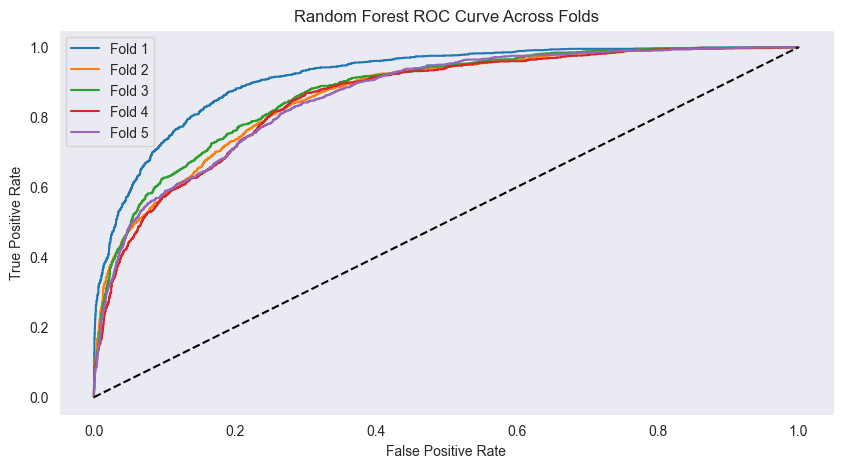

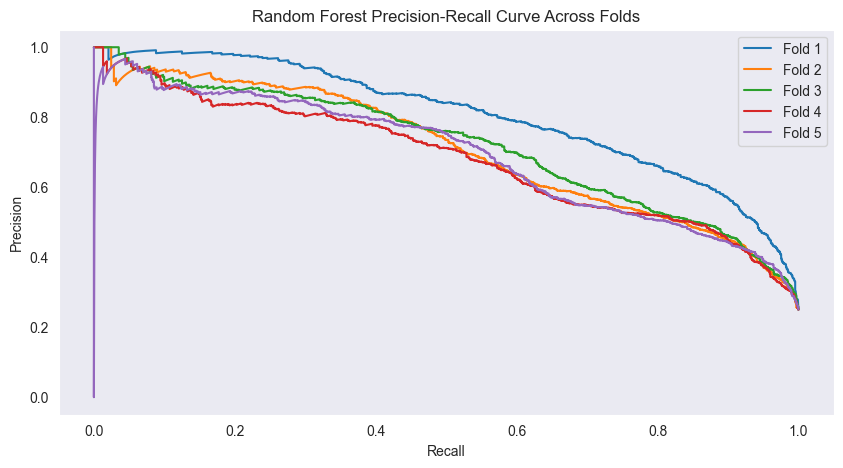

In [23]:

plt.figure(figsize=(10, 5))
for i in range(len(rf_fprs)):
    plt.plot(rf_fprs[i], rf_tprs[i], label=f'Fold {i+1}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Random Forest ROC Curve Across Folds")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
for i in range(len(rf_precisions)):
    plt.plot(rf_recalls[i], rf_precisions[i], label=f'Fold {i+1}')
plt.title("Random Forest Precision-Recall Curve Across Folds")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()


### 📦 Metric Boxplot: XGBoost vs Random Forest

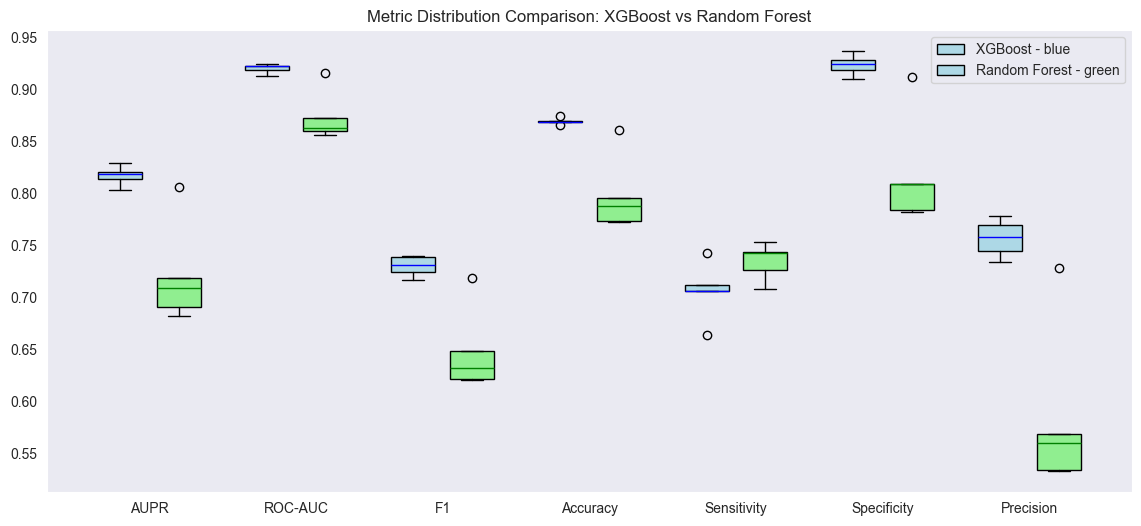

In [24]:

all_metric_names = ["AUPR", "ROC-AUC", "F1", "Accuracy", "Sensitivity", "Specificity", "Precision"]

plt.figure(figsize=(14, 6))
plt.boxplot([np.array(results_all)[:,i] for i in range(7)], 
            positions=np.arange(1, 8) - 0.2, widths=0.3, patch_artist=True,
            boxprops=dict(facecolor='lightblue'), medianprops=dict(color='blue'), labels=all_metric_names)

plt.boxplot([np.array(rf_results_all)[:,i] for i in range(7)], 
            positions=np.arange(1, 8) + 0.2, widths=0.3, patch_artist=True,
            boxprops=dict(facecolor='lightgreen'), medianprops=dict(color='green'))

plt.legend(['XGBoost - blue', 'Random Forest - green'])
plt.title("Metric Distribution Comparison: XGBoost vs Random Forest")
plt.grid()
plt.xticks(np.arange(1, 8), all_metric_names)
plt.show()


### 📋 Random Forest Fold-wise Metrics

In [25]:

rf_df = pd.DataFrame(rf_results_all, columns=all_metric_names)
rf_df.index = [f"Fold {i+1}" for i in range(len(rf_results_all))]
display(rf_df)

print("Random Forest - Mean Metrics:")
display(rf_df.mean())


,AUPR,ROC-AUC,F1,Accuracy,Sensitivity,Specificity,Precision
Fold 1,0.806106,0.916082,0.718009,0.860738,0.707822,0.911840,0.728493
Fold 2,0.708720,0.862666,0.631965,0.788129,0.726227,0.808816,0.559362
Fold 3,0.717995,0.872063,0.647952,0.795236,0.752878,0.809377,0.568696
Fold 4,0.681497,0.855956,0.620557,0.772378,0.743668,0.781963,0.532418
Fold 5,0.690814,0.859510,0.620867,0.773103,0.742134,0.783444,0.533664


Random Forest - Mean Metrics:


AUPR           0.721026
ROC-AUC        0.873255
F1             0.647870
Accuracy       0.797917
Sensitivity    0.734546
Specificity    0.819088
Precision      0.584526
dtype: float64

### 📊 Side-by-side Mean Metrics (XGBoost vs RF)

In [26]:

xgb_mean = pd.DataFrame([np.mean(results_all, axis=0)], columns=all_metric_names, index=["XGBoost"])
rf_mean = pd.DataFrame([np.mean(rf_results_all, axis=0)], columns=all_metric_names, index=["Random Forest"])

display(pd.concat([xgb_mean, rf_mean]))


,AUPR,ROC-AUC,F1,Accuracy,Sensitivity,Specificity,Precision
XGBoost,0.817164,0.920469,0.729821,0.869261,0.705846,0.923842,0.756645
Random Forest,0.721026,0.873255,0.647870,0.797917,0.734546,0.819088,0.584526
